# Eval
---

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates


from helpers import find_missing_date_ranges
from enums import DatasetColumns, WeatherDatasetColumns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## RUN
---

In [2]:
# Helper
def generate_predictions_from_loaded(loaded_generator, weather_features, scaler):
    weather_features = tf.cast(weather_features, tf.float32)
    batch_size = tf.shape(weather_features)[0]

    noise = tf.random.normal([batch_size, 100], dtype=tf.float32)
    predictions_scaled = loaded_generator([noise, weather_features], training=False)

    predictions_with_weather = np.concatenate(
        [predictions_scaled.numpy(), weather_features.numpy()], axis=1
    )
    predictions = scaler.inverse_transform(predictions_with_weather)[:, 0]

    return predictions

In [3]:
# Load data
FILE_NAME = "dataset.csv"
WEATHER_DATASET = "dataset_weather.csv"

original_data = pd.read_csv(
    FILE_NAME,
    parse_dates=[DatasetColumns.STATISTICAL_PERIOD.value],
    index_col=DatasetColumns.STATISTICAL_PERIOD.value,
)

weather_data = pd.read_csv(
    WEATHER_DATASET,
    parse_dates=[WeatherDatasetColumns.DATETIME.value],
    index_col=WeatherDatasetColumns.DATETIME.value,
).asfreq("h")

weather_features = [
    WeatherDatasetColumns.TEMPERATURE_C.value,
    WeatherDatasetColumns.HUMIDITY_PERCENT.value,
]

# Find missing date ranges
gap_start, gap_end = find_missing_date_ranges(
    original_data, DatasetColumns.STATISTICAL_PERIOD.value
)
gap_dates = pd.date_range(start=gap_start, end=gap_end, freq="h")

# Data Splitting
pre_gap_data = original_data[original_data.index < gap_start].asfreq("h")
post_gap_data = original_data[original_data.index >= gap_end].asfreq("h")

pre_gap_train_size = int(len(pre_gap_data) * 0.8)
pre_gap_train = pre_gap_data.iloc[:pre_gap_train_size].copy()
pre_gap_test = pre_gap_data.iloc[pre_gap_train_size:]

pre_gap_train.loc[:, DatasetColumns.PV_YIELD.value] = pre_gap_train[
    DatasetColumns.PV_YIELD.value
].interpolate(method="linear")


pre_weather_data = weather_data[weather_data.index < gap_start].bfill()
pre_weather_data = pre_weather_data.reindex(pre_gap_data.index)
pre_weather_data_test = pre_weather_data.reindex(pre_gap_test.index)


gap_weather_data = weather_data.reindex(gap_dates).ffill()
post_weather_data = weather_data[weather_data.index >= gap_end].bfill()

pre_gap_train_combined = pre_gap_train.join(
    pre_weather_data[weather_features], how="inner"
)
pre_gap_test_combined = pre_gap_test.join(
    pre_weather_data_test[weather_features], how="inner"
)

In [4]:
# LOAD Model
sarimax_model = SARIMAXResults.load("sarimax_model_results.pkl")
sarimax_cv_model = SARIMAXResults.load("sarimax_cv_model_results.pkl")
loaded_generator = tf.keras.models.load_model("solar_gan_generator.h5")
with open("scaler.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

2025-02-28 13:29:35.364966: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-28 13:29:35.368079: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-28 13:29:35.369049: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-02-28 13:29:35.369118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-28 13:29:35.370103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## GAP DATES FORECAST
---

In [5]:
# SARIMAX Generate Prediction on gap_dates_range
exog_gap = gap_weather_data[weather_features]

sarimax_prediction = sarimax_model.forecast(steps=len(gap_dates), exog=exog_gap)
sarimax_prediction = sarimax_prediction.clip(lower=0)

sarimax_cv_prediction = sarimax_cv_model.forecast(steps=len(gap_dates), exog=exog_gap)
sarimax_cv_prediction = sarimax_cv_prediction.clip(lower=0)

In [6]:
# GAN Generate Predicion on gap_dates_range
scaler_weather = MinMaxScaler()
scaler_weather.min_, scaler_weather.scale_ = (
    loaded_scaler.min_[1:],
    loaded_scaler.scale_[1:],
)

gap_weather_scaled = scaler_weather.transform(gap_weather_data[weather_features])

gap_weather_tensor = tf.convert_to_tensor(gap_weather_scaled, dtype=tf.float32)
predictions = generate_predictions_from_loaded(
    loaded_generator, gap_weather_tensor, loaded_scaler
)

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


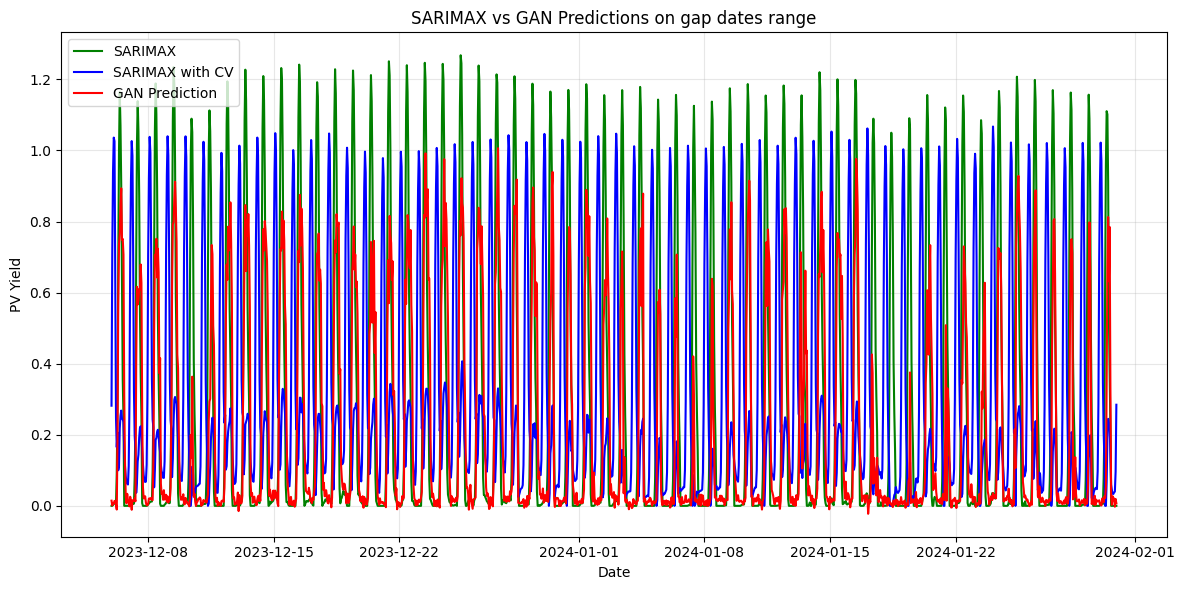

In [7]:
plt.figure(figsize=(12, 6))

plt.plot(gap_dates, sarimax_prediction, label="SARIMAX", color="green")
plt.plot(gap_dates, sarimax_cv_prediction, label="SARIMAX with CV", color="blue")

plt.plot(gap_dates, predictions, label="GAN Prediction", color="red")

plt.legend()
plt.title("SARIMAX vs GAN Predictions on gap dates range")
plt.ylabel("PV Yield")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


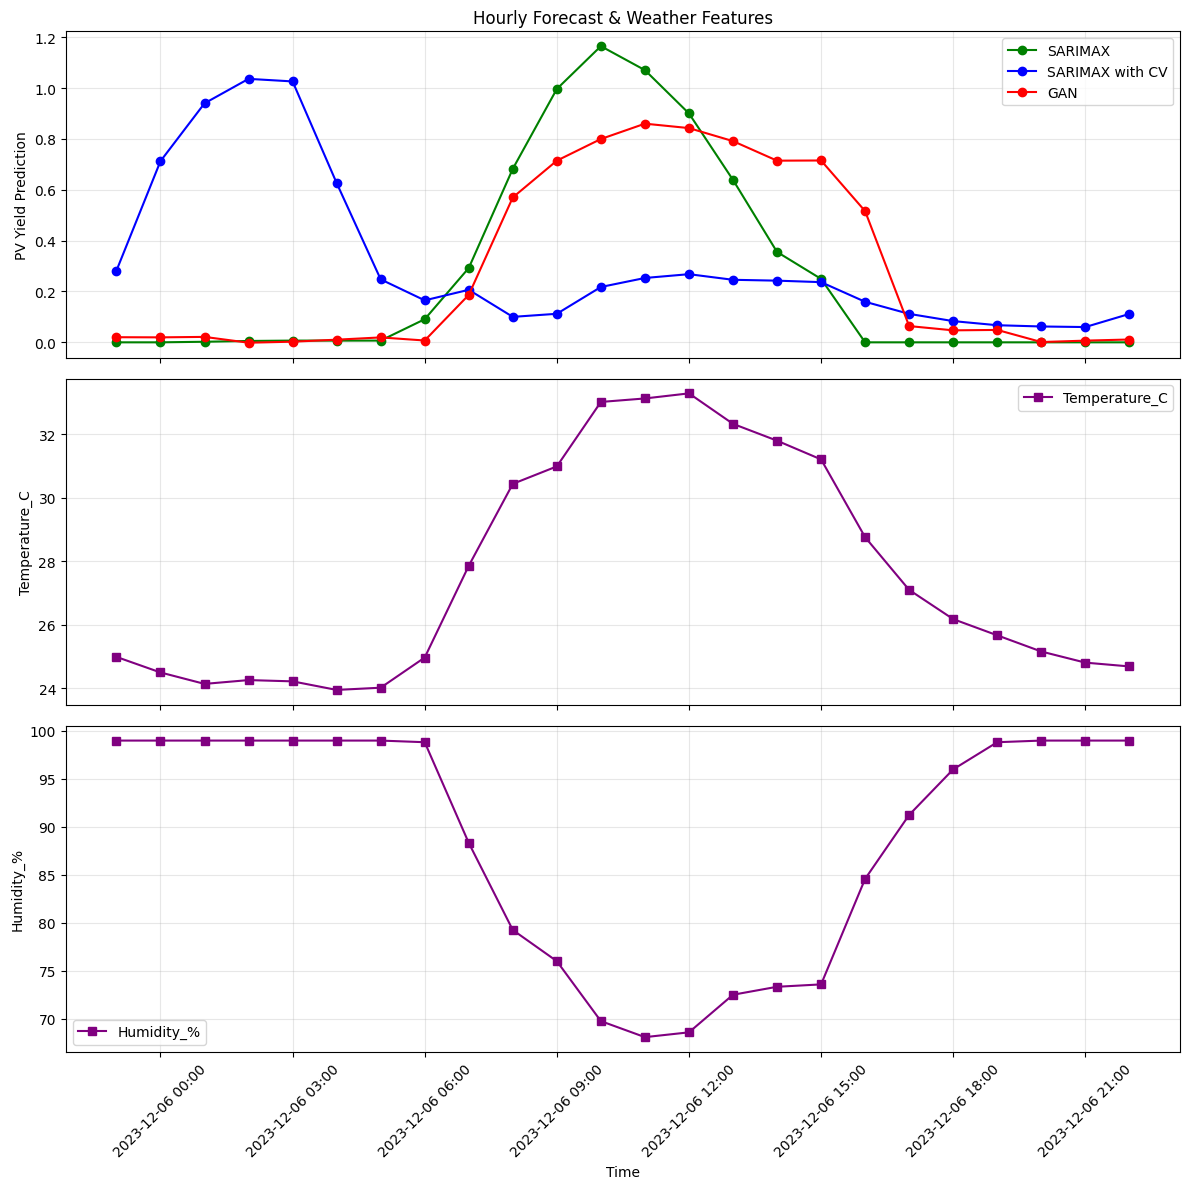

In [ ]:
# First 24 hour forecast
gap_dates_24h = gap_dates[:24]
exog_gap_24h = gap_weather_data.loc[gap_dates_24h, weather_features]


sarimax_prediction_24h = sarimax_model.forecast(steps=24, exog=exog_gap_24h).clip(
    lower=0
)
sarimax_cv_prediction_24h = sarimax_cv_model.forecast(steps=24, exog=exog_gap_24h).clip(
    lower=0
)


gap_weather_scaled_24h = scaler_weather.transform(exog_gap_24h)
gap_weather_tensor_24h = tf.convert_to_tensor(gap_weather_scaled_24h, dtype=tf.float32)

predictions_24h = generate_predictions_from_loaded(
    loaded_generator, gap_weather_tensor_24h, loaded_scaler
)


fig, axes = plt.subplots(len(weather_features) + 1, 1, figsize=(12, 12), sharex=True)


axes[0].plot(
    gap_dates_24h, sarimax_prediction_24h, label="SARIMAX", color="green", marker="o"
)
axes[0].plot(
    gap_dates_24h,
    sarimax_cv_prediction_24h,
    label="SARIMAX with CV",
    color="blue",
    marker="o",
)
axes[0].plot(gap_dates_24h, predictions_24h, label="GAN", color="red", marker="o")
axes[0].set_ylabel("PV Yield Prediction")
axes[0].set_title("Hourly Forecast & Weather Features")
axes[0].legend()
axes[0].grid(True, alpha=0.3)


for i, feature in enumerate(weather_features):
    axes[i + 1].plot(
        gap_dates_24h, exog_gap_24h[feature], label=feature, color="purple", marker="s"
    )
    axes[i + 1].set_ylabel(feature)
    axes[i + 1].grid(True, alpha=0.3)
    axes[i + 1].legend()


axes[-1].set_xlabel("Time")
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## PREDICTION ACCURACY
---

In [ ]:
# SARIMAX Generate Prediction on post_weather_data
exog_gap = post_weather_data[weather_features]

sarimax_prediction = sarimax_model.forecast(steps=len(post_weather_data), exog=exog_gap)
sarimax_prediction = sarimax_prediction.clip(lower=0)

sarimax_cv_prediction = sarimax_cv_model.forecast(steps=len(post_weather_data), exog=exog_gap)
sarimax_cv_prediction = sarimax_cv_prediction.clip(lower=0)

scaler_weather = MinMaxScaler()
scaler_weather.min_, scaler_weather.scale_ = (
    loaded_scaler.min_[1:],
    loaded_scaler.scale_[1:],
)

post_weather_scaled = scaler_weather.transform(post_weather_data[weather_features])

post_weather_tensor = tf.convert_to_tensor(post_weather_scaled, dtype=tf.float32)
predictions = generate_predictions_from_loaded(
    loaded_generator, post_weather_tensor, loaded_scaler
)

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
actual_values = post_gap_data[DatasetColumns.PV_YIELD.value].ffill()

mae_sarimax = mean_absolute_error(actual_values, sarimax_prediction[: len(actual_values)])
mse_sarimax = mean_squared_error(actual_values, sarimax_prediction[: len(actual_values)])
rmse_sarimax = np.sqrt(mse_sarimax)

mae_sarimax_cv = mean_absolute_error(actual_values, sarimax_cv_prediction[: len(actual_values)])
mse_sarimax_cv = mean_squared_error(actual_values, sarimax_cv_prediction[: len(actual_values)])
rmse_sarimax_cv = np.sqrt(mse_sarimax_cv)

mae_gan = mean_absolute_error(actual_values, predictions[: len(actual_values)])
mse_gan = mean_squared_error(actual_values, predictions[: len(actual_values)])
rmse_gan = np.sqrt(mse_gan)

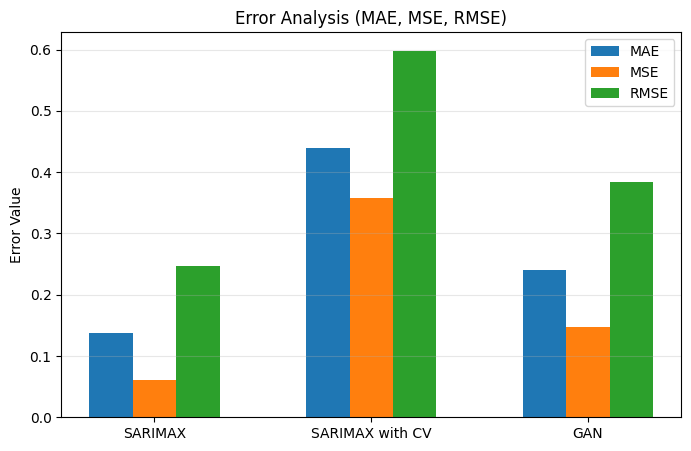

In [53]:
# 1. Error Analysis Plot
plt.figure(figsize=(8, 5))
models = ["SARIMAX", "SARIMAX with CV", "GAN"]
mae_values = [mae_sarimax, mae_sarimax_cv, mae_gan]
mse_values = [mse_sarimax, mse_sarimax_cv, mse_gan]
rmse_values = [rmse_sarimax, rmse_sarimax_cv, rmse_gan]

x = np.arange(len(models))
plt.bar(x - 0.2, mae_values, width=0.2, label="MAE")
plt.bar(x, mse_values, width=0.2, label="MSE")
plt.bar(x + 0.2, rmse_values, width=0.2, label="RMSE")

plt.xticks(x, models)
plt.ylabel("Error Value")
plt.title("Error Analysis (MAE, MSE, RMSE)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

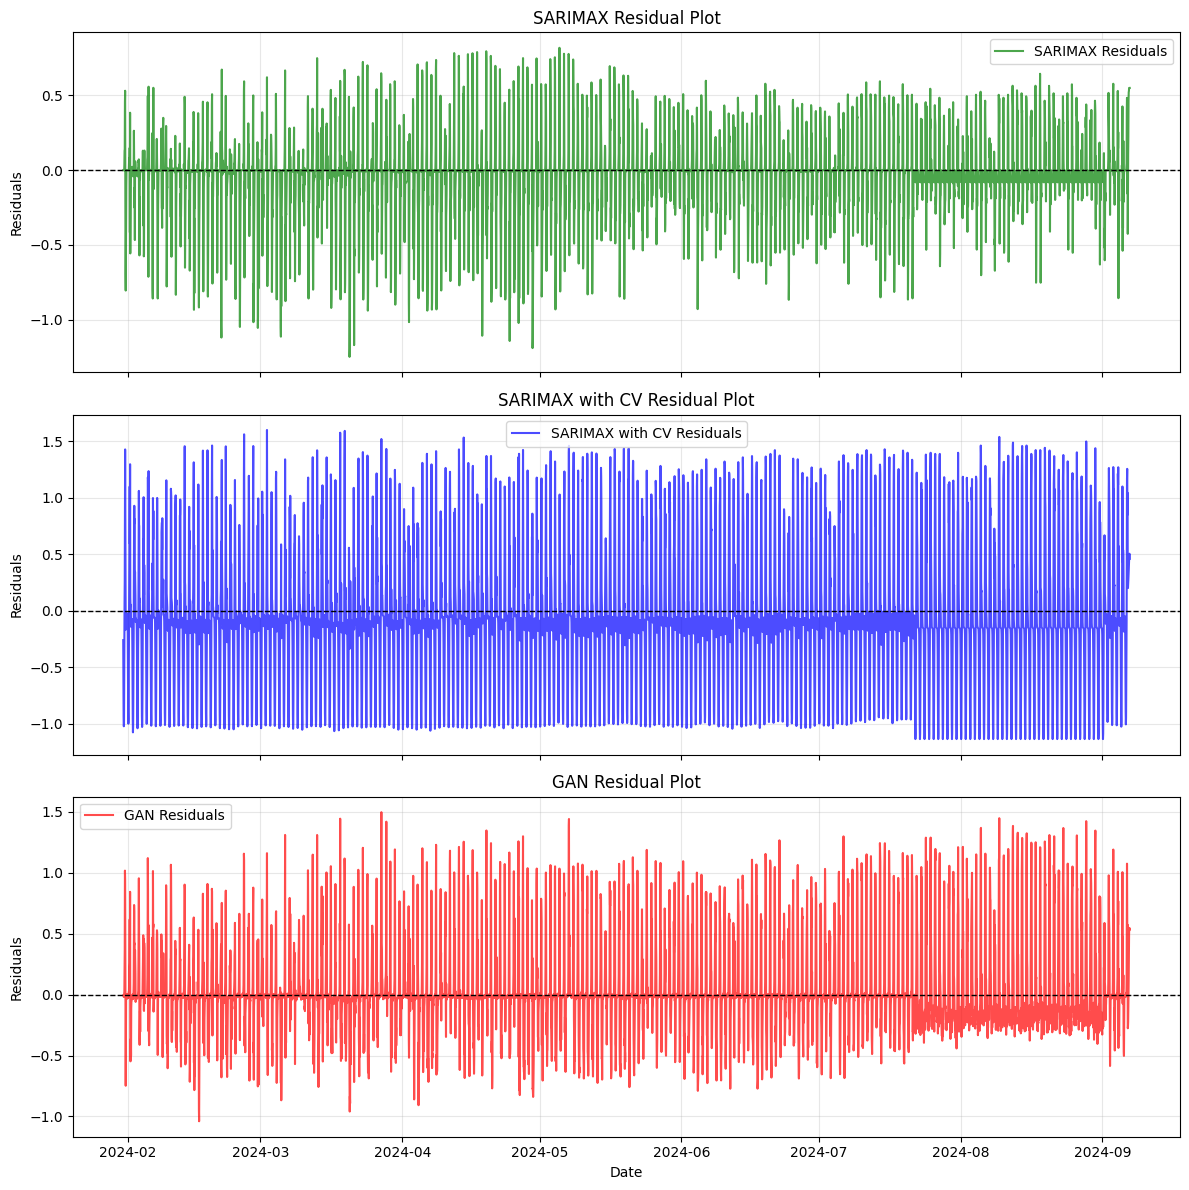

In [46]:
# 2. Residual Plot
residual_sarimax = actual_values.values - sarimax_prediction[: len(actual_values)]
residual_sarimax_cv = actual_values.values - sarimax_cv_prediction[: len(actual_values)]
residual_gan = actual_values.values - predictions[: len(actual_values)]

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Residual SARIMAX
axes[0].plot(
    actual_values.index,
    residual_sarimax,
    label="SARIMAX Residuals",
    color="green",
    alpha=0.7,
)
axes[0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("SARIMAX Residual Plot")
axes[0].set_ylabel("Residuals")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual SARIMAX with CV
axes[1].plot(
    actual_values.index,
    residual_sarimax_cv,
    label="SARIMAX with CV Residuals",
    color="blue",
    alpha=0.7,
)
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("SARIMAX with CV Residual Plot")
axes[1].set_ylabel("Residuals")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Residual GAN
axes[2].plot(
    actual_values.index, residual_gan, label="GAN Residuals", color="red", alpha=0.7
)
axes[2].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[2].set_title("GAN Residual Plot")
axes[2].set_ylabel("Residuals")
axes[2].set_xlabel("Date")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

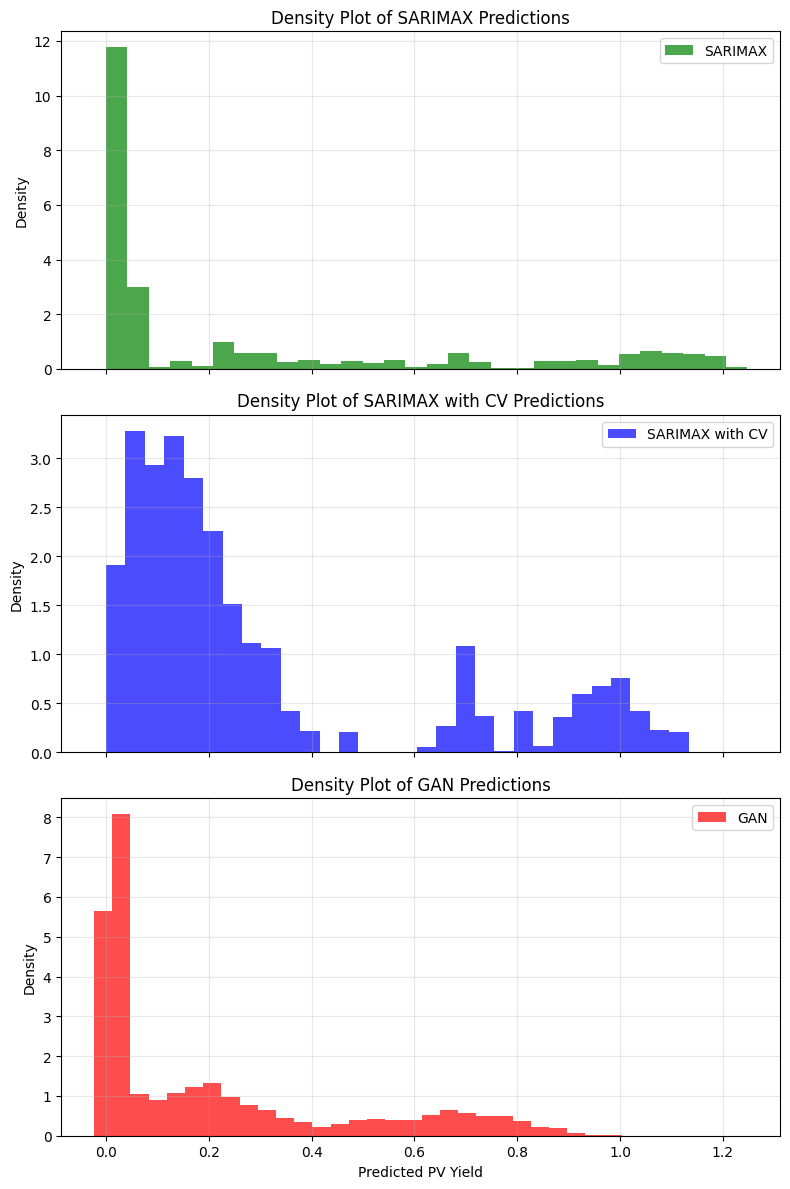

In [47]:
# 3. Density Plot of Predictions
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Density SARIMAX
axes[0].hist(
    sarimax_prediction[: len(actual_values)],
    bins=30,
    alpha=0.7,
    label="SARIMAX",
    density=True,
    color="green",
)
axes[0].set_title("Density Plot of SARIMAX Predictions")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Density SARIMAX with CV
axes[1].hist(
    sarimax_cv_prediction[: len(actual_values)],
    bins=30,
    alpha=0.7,
    label="SARIMAX with CV",
    density=True,
    color="blue",
)
axes[1].set_title("Density Plot of SARIMAX with CV Predictions")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Density GAN
axes[2].hist(
    predictions[: len(actual_values)],
    bins=30,
    alpha=0.7,
    label="GAN",
    density=True,
    color="red",
)
axes[2].set_title("Density Plot of GAN Predictions")
axes[2].set_xlabel("Predicted PV Yield")
axes[2].set_ylabel("Density")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

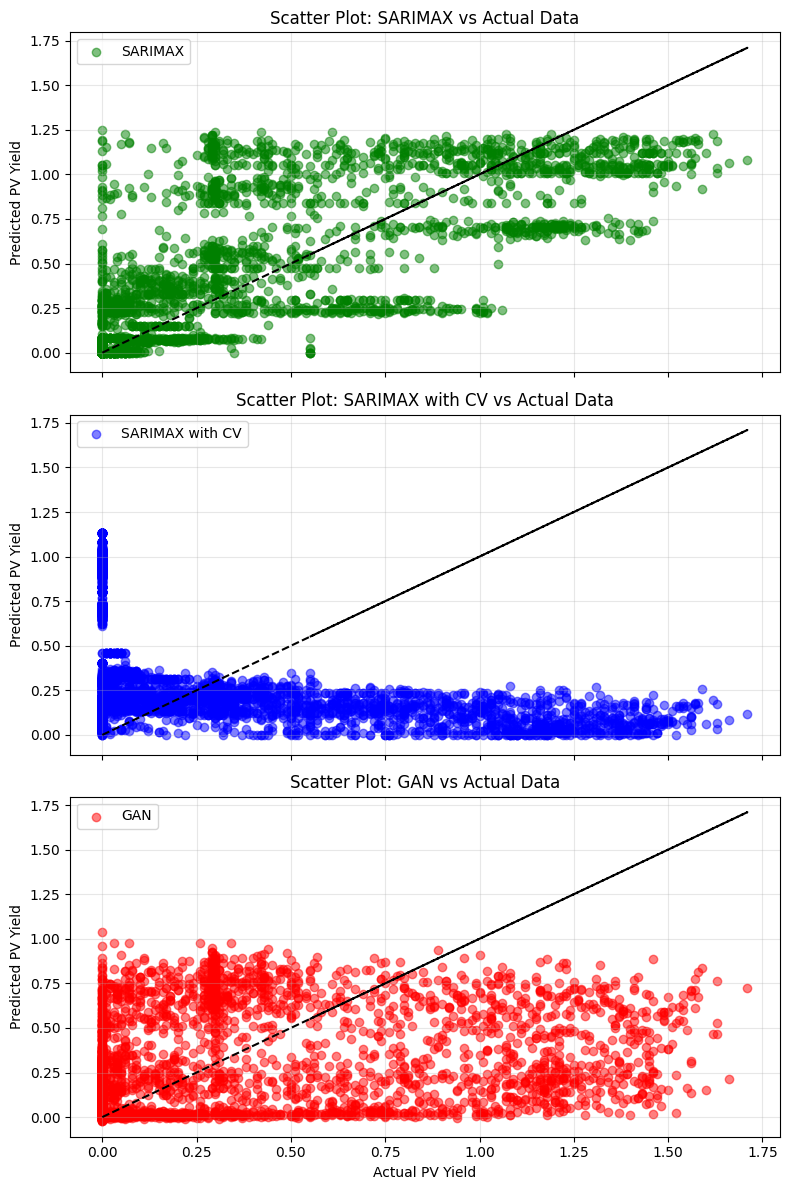

In [48]:
# 4. Scatter Plot: Predictions vs Actual Data
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True, sharey=True)

# Scatter SARIMAX
axes[0].scatter(
    actual_values,
    sarimax_prediction[: len(actual_values)],
    label="SARIMAX",
    color="green",
    alpha=0.5,
)
axes[0].plot(
    actual_values, actual_values, color="black", linestyle="--"
)  # Perfect fit line
axes[0].set_title("Scatter Plot: SARIMAX vs Actual Data")
axes[0].set_ylabel("Predicted PV Yield")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter SARIMAX with CV
axes[1].scatter(
    actual_values,
    sarimax_cv_prediction[: len(actual_values)],
    label="SARIMAX with CV",
    color="blue",
    alpha=0.5,
)
axes[1].plot(
    actual_values, actual_values, color="black", linestyle="--"
)  # Perfect fit line
axes[1].set_title("Scatter Plot: SARIMAX with CV vs Actual Data")
axes[1].set_ylabel("Predicted PV Yield")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Scatter GAN
axes[2].scatter(
    actual_values,
    predictions[: len(actual_values)],
    label="GAN",
    color="red",
    alpha=0.5,
)
axes[2].plot(
    actual_values, actual_values, color="black", linestyle="--"
)  # Perfect fit line
axes[2].set_title("Scatter Plot: GAN vs Actual Data")
axes[2].set_xlabel("Actual PV Yield")
axes[2].set_ylabel("Predicted PV Yield")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()